# Imports

In [1]:
#for reading files
import glob

#math computation and data organization
import numpy as np
import scipy
import pandas as pd

# For loading bars
from tqdm.notebook import tqdm as tqdm

#For image plotting
import skimage.io

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian, threshold_mean
from skimage.measure import regionprops
import cv2

#for fitting
from lmfit import minimize, Parameters, fit_report

#for image registration
from skimage.registration import phase_cross_correlation
import os

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import gridspec

#Movie
import celluloid as cell
import matplotlib.animation as animation

#for saving data
import csv

#custom analysis packages
import aster_packages as ap

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:

# Figure Formatting
import matplotlib.pyplot as plt
import matplotlib as mpl

figwidth = 4
plt.rcParams["figure.figsize"] = [figwidth, figwidth * 1105 / 1920
                                  ]  # figure size in inches
plt.rcParams["lines.linewidth"] = 2  # line width in points
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"

plt.rcParams["font.style"] = "normal"
plt.rcParams["font.weight"] = "heavy" #chick this later maybe the source of weirdness in labels (ANA READ THIS)
plt.rcParams["font.size"] = 13.0
plt.rcParams["axes.labelweight"] = "bold"  # weight of the x and y labels
plt.rcParams["axes.spines.right"] = True
plt.rcParams[
    "axes.formatter.useoffset"] = True  # If True, the tick label formatter
plt.rcParams["xtick.major.size"] = 10  # major tick size in points
plt.rcParams["xtick.minor.size"] = 4  # minor tick size in points
plt.rcParams["xtick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.major.size"] = 10  # major tick size in points
plt.rcParams["ytick.minor.size"] = 4  # minor tick size in points
plt.rcParams["ytick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["legend.fontsize"] = 10
plt.rcParams[
    "legend.labelspacing"] = 0.1  # the vertical space between the legend entries in fraction of fontsize
plt.rcParams["legend.shadow"] = False
plt.rcParams[
    "legend.frameon"] = True  # whether or not to draw a frame around legend
plt.rcParams[
    'axes.unicode_minus'] = False  # fix glyph error by using normal hyphens
plt.rcParams.update({"text.usetex": True, 
             "font.family": "Times"})
mpl.rc("figure", dpi=200)

color_background = '#E5E0D5'

# Data Imports

Function to import aster images into a list of length 3 each containing an image array for each channel with shape (lenth of frames, n by m image shape)

In [3]:
def parse_channelarrays(file, channel_list=['405', '480', 'Cherry']):
    """
    reads a list of directories and returns arrays of images separated by channel
    
    Inputs:
    file: the directory name (includes the position index) i.e.
            '../../data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/Pos1/'
    """
    
    #3 channels we care about
    channel_id = ['bnd', 'unbnd', 'mot'] #Don't change these names
    #included frames (ome=all)
    included_frames = '*ome*.tif'
    
    arrays = []
    for i, channel in enumerate(channel_list):    
        #appends all the file names
        im_files=np.sort(glob.glob(file + channel + '/' + included_frames))
        
        #turn into images
        images=ap.file_to_image(im_files)
        
        #save image array to list
        arrays.append(images)
        
    return arrays    

In [4]:
#gabes version of file name
gname = '../../data/aster/2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/Pos1/'
arrs = parse_channelarrays(gname)

In [5]:
def grab_expparams(gname):
    '''
    assumes unix file separation - rewrite if you have a PC
    '''
    exp_file = gname.split('/')[-3]
    interval = int(exp_file.split('sInter')[0])
    motor_conc = float(exp_file.split('_')[1].split('uM')[0])
    motor_type = exp_file.split('_')[2]
    ATP_conc = float(exp_file.split('_')[4].split('uM')[0])
    tubulin_conc = float(exp_file.split('_')[5].split('uM')[0])
    probe_conc = float(exp_file.split('_')[7].split('uM')[0])
    probe_type = exp_file.split('_')[8]
    
    exp_params = {'exp_file':exp_file,
                 'interval':interval,
                 'motor_conc':motor_conc,
                 'motor_type':motor_type,
                 'ATP_conc':ATP_conc,
                 'tubulin_conc':tubulin_conc,
                 'probe_conc':probe_conc,
                 'probe_type':probe_type}
    return exp_params

In [6]:
exp_params = grab_expparams(gname)

In [7]:
def grab_dark_avg(file_path_dark):
    """
    input for example:
    file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
    """
    dark_files = np.sort(glob.glob(file_path_dark))
    dark_ims = ap.file_to_image(dark_files)
    dark_avg = np.average(dark_ims, axis=0)
    return dark_avg

In [8]:
file_path_dark = '../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*'
dark_avg = grab_dark_avg(file_path_dark)

In [9]:
def grab_calparams(file_path_cal):
    #read the DataFrame
    cal_params = pd.read_csv(cal_file_path+cal_file_folder+cal_file_name)

    #add hill=1 if no hill specified
    if len(cal_params)==3:
        cal_params.loc[-1] = [3, 'nhill', 1, 0]
    
    #reindex
    cal_params = cal_params.set_index('Param')
    
    #drop the unnamed colum (from index of text file)
    cal_params = cal_params.drop(columns='Unnamed: 0')
    
    return cal_params

In [10]:
cal_file_path = '../../analyzed_data/atp_cal/'
cal_file_folder = '2023-12-16_A81D_Cal/'
cal_file_name = 'df_fit_example'
cal_params = grab_calparams(cal_file_path+cal_file_folder+cal_file_name)

## Normalize Images
This corrects for uneven illumination. The light gradient that comes from instrumentation "should" be the same for each frame. Here, take the first frame of the image sequence and create a normalization matrix. This matrix is created by dividing each pixel in the image by the maximum pixel value, so that when you multiply the original image by the normalization matrix, the first frame will be a homogeneous image with the highest pixel value. All future frames can be multiplied by the matrix to remove the systematic light gradient

In [11]:
def backSubtract(arrs, dark_avg):
    return [arr-dark_avg for arr in arrs] # save processed images

In [12]:
arrs_sub = backSubtract(arrs, dark_avg)

In [13]:
def intersect(arrs):
    _, numRows, numCols=arrs[0].shape
    
    #iterate through frame numbers
    severeIntersection=np.ones_like(dark_avg);
    
    for fr in range(arrs[0].shape[0]): # for every timepoint
        #iterate through channels:
        ## Process the ATP channels first!
        im_bins=[]
        for arr in arrs_sub[:2]: #exclude the motor channel!
            im_bin = (arr[fr,:,:] > threshold_otsu(arr[fr,:,:])).astype(np.uint8)
            im_bins.append(im_bin)
        intersectionBinImg=np.multiply(*im_bins) # This is defined for each frame/timepoint; it is the intersection between both channels' masks
        severeIntersection=np.multiply(severeIntersection, intersectionBinImg) # This accumulates the most severe intersection possible such that after iteration over all frames, all pixels not = 0 are visible/illuminated in every frame and every channel

    return np.where(severeIntersection.astype(int)) #returns where =1 (or True)

In [14]:
mask_coords=intersect(arrs_sub)

In [15]:
def fit_bivariate_quadratic_anyShape(vals, coord):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    binary_im (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Flatten the matrices for the least squares fitting
    I_flat = coord[0]
    J_flat = coord[1]
    Z_flat = vals

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly_anyShape(vals,coord):
    """ Evaluates best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic_anyShape(vals, coord);
    I, J = coord[0], coord[1]
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted

In [43]:
def norm_unev(arrs_sub, mask_coords):
    #norm_mats = []
    arrs_ev = []
    
    for arr in arrs_sub:
        #compute the bivariate filter
        biv_filt = np.zeros_like(arr[0])
        biv_filt[mask_coords] = evaluateBivPoly_anyShape(arr[0, :, :][mask_coords], mask_coords)
        #norm_mats.append(norm_mat)
        
        #scale the normalization matrix such that the average value after multiplication is the same as the bs image
        scalar = np.mean(arr[0][mask_coords])/np.mean(arr[0][mask_coords]/norm_mats[0][mask_coords])
        norm_mat = scalar/biv_filt
        
        arrs_ev_temp = np.zeros_like(arr)
        arrs_ev_temp[:, mask_coords[0], mask_coords[1]]=arr[:, mask_coords[0], mask_coords[1]]*norm_mat[mask_coords]
        
        arrs_ev.append(arrs_ev_temp)
        
    return arrs_ev

In [44]:
abnormal=norm_unev(arrs_sub, mask_coords)

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_23545/1002508544.py:13: RuntimeWarning: divide by zero encountered in true_divide
  norm_mat = scalar/biv_filt


In [47]:
abnormal[0].shape

(200, 1200, 1920)

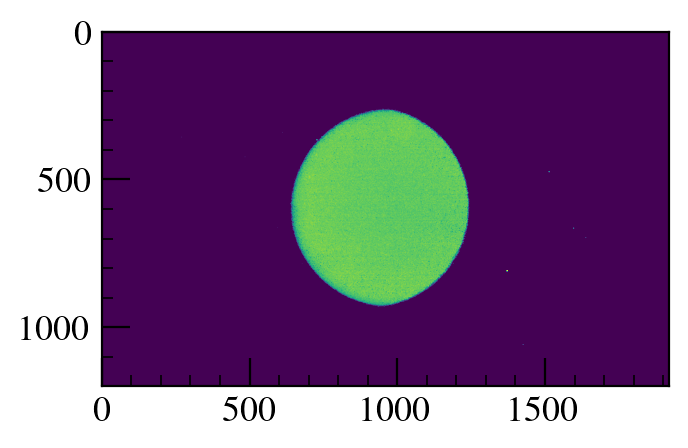

In [52]:
fig, ax = plt.subplots()
ax.imshow(abnormal[0][0,:,:],vmin=0, vmax=500)

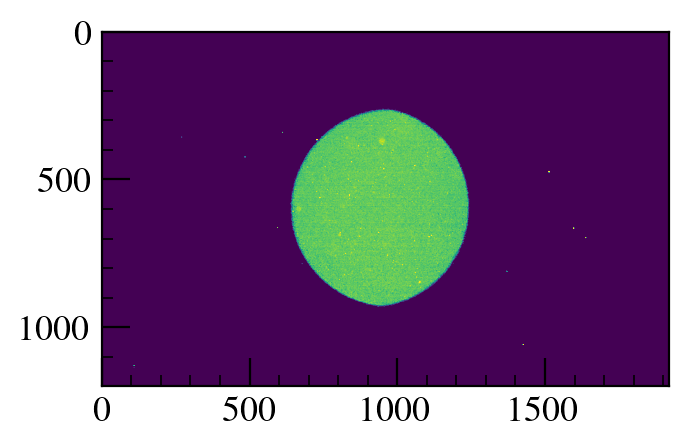

In [54]:
fig, ax = plt.subplots()
ax.imshow(abnormal[2][0,:,:],vmin=0, vmax=500)

In [26]:
np.mean(norm_mats[0][mask_coords]), np.mean(arrs_sub[0][0][mask_coords])

(380.85414669341594, 380.85414669341844)

In [27]:
np.mean(arrs_sub[0][0][mask_coords])/np.mean(arrs_sub[0][0][mask_coords]/norm_mats[0][mask_coords])

381.08343966822446

In [16]:
norm_mats = []
for arr in arrs_sub:
    norm_mat = np.zeros_like(dark_avg)
    norm_mat[mask_coords] = evaluateBivPoly_anyShape(arr[0, :, :][mask_coords], mask_coords)
    norm_mats.append(norm_mat)

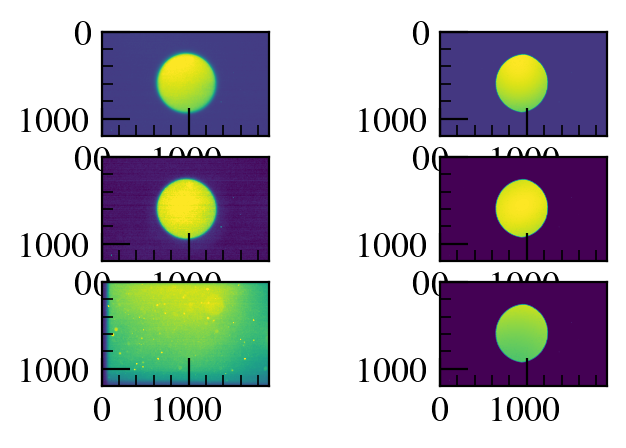

In [17]:
fig, ax = plt.subplots(3, 2)
ax[0][0].imshow(arrs_sub[0][0], vmin=norm_mats[0].min(), vmax=norm_mats[0].max())
ax[0][1].imshow(norm_mats[0])
ax[1][0].imshow(arrs_sub[1][0], vmin=norm_mats[1].min(), vmax=norm_mats[1].max())
ax[1][1].imshow(norm_mats[1])
ax[2][0].imshow(arrs_sub[2][0], vmin=norm_mats[2].min(), vmax=norm_mats[2].max())
ax[2][1].imshow(norm_mats[2])

In [113]:
testImg=arrs[0][0,:,:]
fit_bivariate_quadratic_anyShape(testImg[np.where(testBackMask)],
                                 np.where(testBackMask))

array([-3.47758592e-04, -4.53934814e-04,  1.07272348e-05,  2.26613362e-01,
        8.09367339e-01,  1.93676849e+03])

Find the illuminated region for the projector channels and apply the bivariate polynomial

next function is for circles with specified center and radius

In [ ]:
def BivPolyNormMatCirc(im, cent, radius, r_edge):
    # Make a binary image using the center and radius of the illumination patterns
    I, J = np.meshgrid(np.arange(im.shape[0]), np.arange(im.shape[1]), indexing='ij')
    testcirc = (I-illumavgcent[1])**2+(J-illumavgcent[0])**2
    coords = np.where(testcirc<=(radius-r_edge)**2)
    vals = im[coords]
    
    #Apply the bivariate polynomial fit for the ones region
    biv_filt = evaluateBivPoly_anyShape(vals, coords)
    alpha_filt = np.nanmean(biv_filt)/biv_filt

    #put the bivariate filter in the shape of the image
    im_biv = np.zeros(im.shape)
    im_biv[coords] += biv_filt
    #put the alpha filter in the shape of the image
    alpha = np.zeros(im.shape)
    alpha[coords] += alpha_filt

    return alpha

In [ ]:
bnd_alpha = BivPolyNormMatCirc(im_arraybnd_bs[0], illumavgcent_bnd, illumradius_bnd, 30)
bnd_arraynorm = im_arraybnd_bs_nonneg*bnd_alpha

unbnd_alpha = BivPolyNormMatCirc(im_arrayunbnd_bs_nonneg[0], illumavgcent_unbnd, illumradius_unbnd, 30)
unbnd_arraynorm = im_arrayunbnd_bs_nonneg*unbnd_alpha
